In [3]:
%matplotlib inline

import hops_enrich

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import glob


## Determine enrichment of peptides in all files

#### Generate clusters of all sequences seen in the hA5, hA6, ancA5/A6, and altAll samples

Will generate `.cluster` files, one each for hA5, hA6, aA5A6, and alt.  

In [4]:

# Go through all-pooled counts files
for all_seq_file in glob.glob("*_all_pooled.counts"):

    # Get list of all sequences seen in these files
    seq_list = []
    with open(all_seq_file) as f:
        for line in f:
            seq_list.append(line.split()[0].strip())
    
    
    # Generate clusters
    cluster_file = f"{all_seq_file.split('.counts')[0]}.cluster"
    hops_enrich.cluster.cluster_seqs(seq_list,
                                     epsilon=1,
                                     min_neighbors=1,
                                     dist_function="simple",
                                     out_file=cluster_file)

#### Calculate enrichment of each peptide for each pair of counts files

Will generate `.enrich` and `.enrich.pdf` files.  `.enrich` files hold enrichments calculated for each peptide for the given protein sample.  The `.enrich.pdf` files hold the enrichment histograms with Gaussian fits for each sample.

hA5 1


/Users/harmsm/work/programming/git-clones/hops_enrich/hops_enrich/enrich.py:434: RuntimeWarning: divide by zero encountered in double_scalars
  weight = 1/sigma
/Users/harmsm/work/programming/git-clones/hops_enrich/hops_enrich/enrich.py:462: RuntimeWarning: invalid value encountered in double_scalars
  seq_weight[c] = seq_weight[c]/total


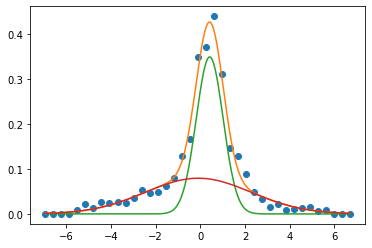

hA5 2


/Users/harmsm/work/programming/git-clones/hops_enrich/hops_enrich/enrich.py:434: RuntimeWarning: divide by zero encountered in double_scalars
  weight = 1/sigma
/Users/harmsm/work/programming/git-clones/hops_enrich/hops_enrich/enrich.py:462: RuntimeWarning: invalid value encountered in double_scalars
  seq_weight[c] = seq_weight[c]/total


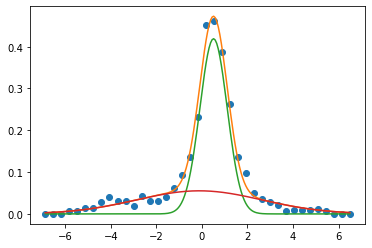

hA5 pooled


/Users/harmsm/work/programming/git-clones/hops_enrich/hops_enrich/enrich.py:434: RuntimeWarning: divide by zero encountered in double_scalars
  weight = 1/sigma
/Users/harmsm/work/programming/git-clones/hops_enrich/hops_enrich/enrich.py:462: RuntimeWarning: invalid value encountered in double_scalars
  seq_weight[c] = seq_weight[c]/total


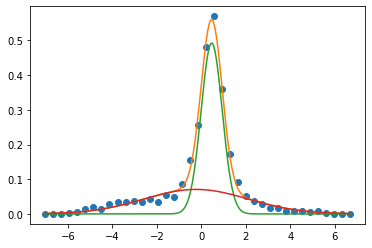

hA6 1


/Users/harmsm/work/programming/git-clones/hops_enrich/hops_enrich/enrich.py:434: RuntimeWarning: divide by zero encountered in double_scalars
  weight = 1/sigma
/Users/harmsm/work/programming/git-clones/hops_enrich/hops_enrich/enrich.py:462: RuntimeWarning: invalid value encountered in double_scalars
  seq_weight[c] = seq_weight[c]/total


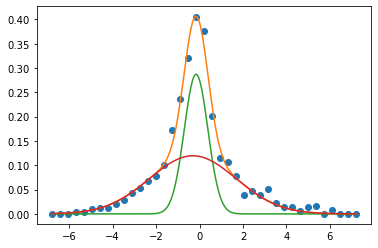

hA6 2


/Users/harmsm/work/programming/git-clones/hops_enrich/hops_enrich/enrich.py:434: RuntimeWarning: divide by zero encountered in double_scalars
  weight = 1/sigma
/Users/harmsm/work/programming/git-clones/hops_enrich/hops_enrich/enrich.py:462: RuntimeWarning: invalid value encountered in double_scalars
  seq_weight[c] = seq_weight[c]/total


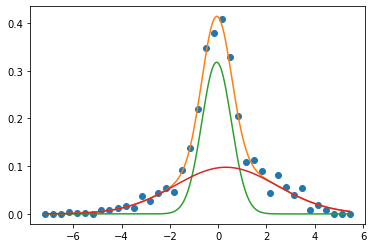

hA6 pooled


/Users/harmsm/work/programming/git-clones/hops_enrich/hops_enrich/enrich.py:434: RuntimeWarning: divide by zero encountered in double_scalars
  weight = 1/sigma
/Users/harmsm/work/programming/git-clones/hops_enrich/hops_enrich/enrich.py:462: RuntimeWarning: invalid value encountered in double_scalars
  seq_weight[c] = seq_weight[c]/total


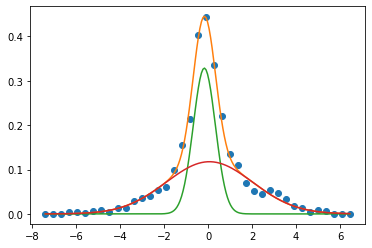

aA5A6 1


/Users/harmsm/work/programming/git-clones/hops_enrich/hops_enrich/enrich.py:434: RuntimeWarning: divide by zero encountered in double_scalars
  weight = 1/sigma
/Users/harmsm/work/programming/git-clones/hops_enrich/hops_enrich/enrich.py:462: RuntimeWarning: invalid value encountered in double_scalars
  seq_weight[c] = seq_weight[c]/total


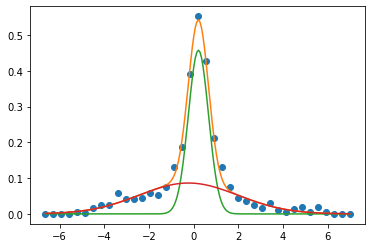

aA5A6 2


/Users/harmsm/work/programming/git-clones/hops_enrich/hops_enrich/enrich.py:434: RuntimeWarning: divide by zero encountered in double_scalars
  weight = 1/sigma
/Users/harmsm/work/programming/git-clones/hops_enrich/hops_enrich/enrich.py:462: RuntimeWarning: invalid value encountered in double_scalars
  seq_weight[c] = seq_weight[c]/total


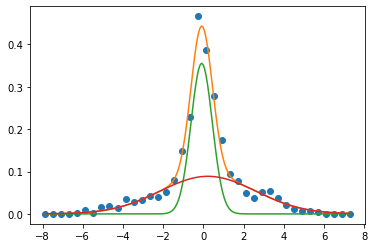

aA5A6 pooled


/Users/harmsm/work/programming/git-clones/hops_enrich/hops_enrich/enrich.py:434: RuntimeWarning: divide by zero encountered in double_scalars
  weight = 1/sigma
/Users/harmsm/work/programming/git-clones/hops_enrich/hops_enrich/enrich.py:462: RuntimeWarning: invalid value encountered in double_scalars
  seq_weight[c] = seq_weight[c]/total


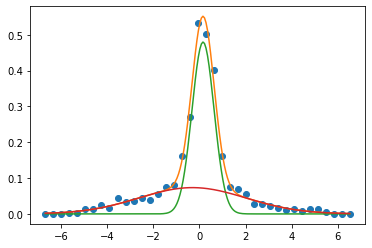

alt 1


/Users/harmsm/work/programming/git-clones/hops_enrich/hops_enrich/enrich.py:434: RuntimeWarning: divide by zero encountered in double_scalars
  weight = 1/sigma
/Users/harmsm/work/programming/git-clones/hops_enrich/hops_enrich/enrich.py:462: RuntimeWarning: invalid value encountered in double_scalars
  seq_weight[c] = seq_weight[c]/total


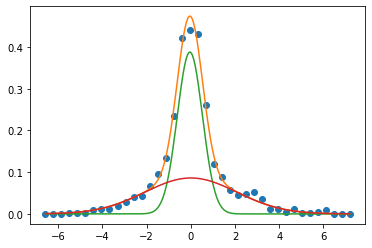

alt 2


/Users/harmsm/work/programming/git-clones/hops_enrich/hops_enrich/enrich.py:434: RuntimeWarning: divide by zero encountered in double_scalars
  weight = 1/sigma
/Users/harmsm/work/programming/git-clones/hops_enrich/hops_enrich/enrich.py:462: RuntimeWarning: invalid value encountered in double_scalars
  seq_weight[c] = seq_weight[c]/total


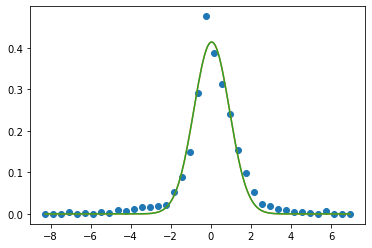

alt pooled


/Users/harmsm/work/programming/git-clones/hops_enrich/hops_enrich/enrich.py:434: RuntimeWarning: divide by zero encountered in double_scalars
  weight = 1/sigma
/Users/harmsm/work/programming/git-clones/hops_enrich/hops_enrich/enrich.py:462: RuntimeWarning: invalid value encountered in double_scalars
  seq_weight[c] = seq_weight[c]/total


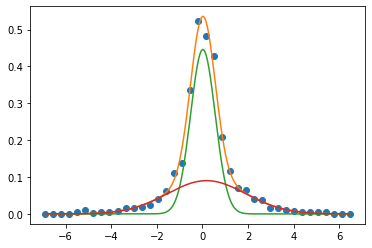

In [5]:

def get_enrichment(conv_file,comp_file,cluster_file,out_file=None,min_counts=6):

    conv = hops_enrich.enrich.load_counts_file(conv_file)
    comp = hops_enrich.enrich.load_counts_file(comp_file)
    clusters, _ = hops_enrich.cluster.read_cluster_file(cluster_file)
    enrichment, _, _, gaussian_stats = hops_enrich.enrich.calc_enrichment(conv,comp,clusters,min_counts=min_counts,out_file=out_file)
    
    unresponsive_mean = np.max(gaussian_stats[0])
    
    for k in enrichment:
        enrichment[k] = enrichment[k] - unresponsive_mean
        
    return enrichment, gaussian_stats


enrichment = {}
gaussian_stats = {}
for sample in ["hA5","hA6","aA5A6","alt"]:
    for x in ["1","2","pooled"]:
    
        print(sample,x)
    
        key = f"{sample}_{x}"
    
        e, gs = get_enrichment(f"{sample}_conv_{x}.counts",
                               f"{sample}_comp_{x}.counts",
                               f"{sample}_all_pooled.cluster",
                               out_file=f"{sample}_{x}.enrich",
                               min_counts=6)
        
        enrichment[key] = e
        gaussian_stats[key] = gs




#### Construct data frames holding all common peptide enrichments between different experiments

+ `aA5A6_df` (`hA5-hA6-aA5A6_enrichment.txt`) has enrichment values for all peptides in common between hA5, hA6, and aA5A6.
+ `alt_df` (`hA5-hA6-alt_enrichment.txt`) has enrichment values for all peptides in common between hA5, hA6, and alt.
+ `all_df` (`hA5-hA6-aA5A6-alt_enrichment.txt`) has enrichment values for all peptides in common between hA5, hA6, aA5A6, and alt.

In [6]:

def build_df(enrich,names):
    
    sets = []
    for e in enrich:
        sets.append(set(e.keys()))
    
    shared_seq = sets[0]
    for s in sets[1:]:
        shared_seq = shared_seq.intersection(s)
        
    out_dict = {"seq":[]}
    for n in names:
        out_dict[n] = []
    for seq in shared_seq:
        out_dict["seq"].append(seq)
        for i, e in enumerate(enrich):
            out_dict[names[i]].append(e[seq])
        
    return pd.DataFrame(out_dict)

aA5A6_df = build_df([enrichment["hA5_pooled"],enrichment["hA6_pooled"],enrichment["aA5A6_pooled"]],
                    ["hA5","hA6","aA5A6"])
aA5A6_df.to_csv("hA5-hA6-aA5A6_enrichment.txt")

alt_df = build_df([enrichment["hA5_pooled"],enrichment["hA6_pooled"],enrichment["alt_pooled"]],
                    ["hA5","hA6","alt"])
alt_df.to_csv("hA5-hA6-alt_enrichment.txt")

all_df = build_df([enrichment["hA5_pooled"],enrichment["hA6_pooled"],enrichment["aA5A6_pooled"],enrichment["alt_pooled"]],
                    ["hA5","hA6","aA5A6","alt"])
all_df.to_csv("hA5-hA6-aA5A6-alt_enrichment.txt")

## Fig 2A, S4
#### Enrichment histograms and Gaussian fits

After running the cells above, see `hA5_pooled.enrich.pdf` (Fig 2A, S4A), `hA6_pooled.enrich.pdf` (Fig S4B), `aA5A6_pooled.enrich.pdf` (Fig S4C), and `alt_pooled.enrich.pdf` (Fig S4D).  

## Fig S3

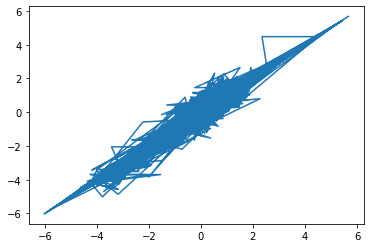

In [22]:
def load_enrichment_csv(enrich_csv):
    
    with open(enrich_csv) as f:
        for l in f:
            header = l.strip()[1:].split()
            break
            
    return pd.read_csv(enrich_csv,names=header,skiprows=1,delim_whitespace=True)
    
    
df = load_enrichment_csv("hA5_pooled.enrich")
no_cluster_needed_to_estimate = np.logical_not(np.isnan(df.E_from_seq))
E_from_clusters = df.loc[no_cluster_needed_to_estimate,"E"]
E_from_seq = df.loc[no_cluster_needed_to_estimate,"E_from_seq"]

fig, ax = plt.subplots(1,figsize=(5,5))

plt.plot(E_from_seq,E_from_clusters)

